# Seminar 5. Topic Modeling
### ... in a nutshell:

<img src="https://moj-analytical-services.github.io/NLP-guidance/LDAresults.png" alt="lda" style="width: 600px;"/>

## Content
* Data preparation
* Feature extraction
* Train model
* Data analysis

Partially pased on [this blogpost](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) by Selva Prabhakaran.

In [1]:
if False:
    !pip install pyldavis PyStemmer seaborn nltk gensim nltk pandas tqdm

In [2]:
from collections import Counter
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import logging
import random
import re
import sys
from typing import List
import warnings

from IPython.display import display, Code
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from pygments.lexers import get_lexer_by_name
from pygments.token import Token
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
from tqdm.auto import tqdm

from subtokenizing import TokenParser

warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

%matplotlib inline

/home/egor/workspace/nlp-course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


## Data preparation
* Please check how to download data on previous seminar
* Read data into DataFrame

In [3]:
base_url = Path("../nlp-course-lecture04/dataset")


def read_data(jsonl_loc: str, max_n_rows: int = -1) -> pd.DataFrame:
    """Read JSONL file to pandas.DataFrame"""
    with open(jsonl_loc) as f:
        data = []
        for i, line in enumerate(f):
            try:
                data.append(json.loads(line))
            except:
                print(f"line {i} has problems")
            if max_n_rows > 0:
                if len(data) >= max_n_rows:
                    break
    return pd.DataFrame(data)


print("Reading data...")
df_train = read_data(str(base_url / "train_shuffled.jsonl"), 30000)

Reading data...
line 6387 has problems


In [4]:
df_train[["language", "func_name", "original_string", "code_tokens"]].head()

,language,func_name,original_string,code_tokens
0,javascript,InvalidValidationRuleParameter,function InvalidValidationRuleParameter(rulePa...,"[function, InvalidValidationRuleParameter, (, ..."
1,java,Strings.pathEquals,"public static boolean pathEquals(String path1,...","[public, static, boolean, pathEquals, (, Strin..."
2,ruby,Phonelib.PhoneFormatter.raw_national,def raw_national\n return nil if sanitize...,"[def, raw_national, return, nil, if, sanitized..."
3,go,WatchSrvVSchema,func (ts *Server) WatchSrvVSchema(ctx context....,"[func, (, ts, *, Server, ), WatchSrvVSchema, (..."
4,javascript,,function (evt) {\n // Ignore input ...,"[function, (, evt, ), {, // Ignore input field..."


In [5]:
def display_code_example(df: pd.DataFrame, language: str, n_examples: int = 1) -> None:
    """Display example(s) of function from DataFrame"""
    assert n_examples >= 1
    for i, code in enumerate(df_train[df_train["language"] == language]["original_string"]):
        display(Code(code, language=language))
        if i + 1 >= n_examples:
            break

In [6]:
print("Python examples")
display_code_example(df_train, "python")

Python examples


def __build_python_module_cache(self):
        """Recursively walks through the b2/src subdirectories and
        creates an index of base module name to package name. The
        index is stored within self.__python_module_cache and allows
        for an O(1) module lookup.

        For example, given the base module name `toolset`,
        self.__python_module_cache['toolset'] will return
        'b2.build.toolset'

        pkgutil.walk_packages() will find any python package
        provided a directory contains an __init__.py. This has the
        added benefit of allowing libraries to be installed and
        automatically avaiable within the contrib directory.

        *Note*: pkgutil.walk_packages() will import any subpackage
        in order to access its __path__variable. Meaning:
        any initialization code will be run if the package hasn't
        already been imported.
        """
        cache = {}
        for importer, mname, ispkg in pkgutil.walk_packages(b2.__path__, prefix='b2.'):
            basename = mname.split('.')[-1]
            # since the jam code is only going to have "import toolset ;"
            # it doesn't matter if there are separately named "b2.build.toolset" and
            # "b2.contrib.toolset" as it is impossible to know which the user is
            # referring to.
            if basename in cache:
                self.manager.errors()('duplicate module name "{0}" '
                                      'found in boost-build path'.format(basename))
            cache[basename] = mname
        self.__python_module_cache = cache

In [7]:
print("Java examples")
display_code_example(df_train, "java", 2)

Java examples


public static boolean pathEquals(String path1, String path2) {
        return cleanPath(path1).equals(cleanPath(path2));
    }

@Override
  public Long scard(final byte[] key) {
    checkIsInMultiOrPipeline();
    client.scard(key);
    return client.getIntegerReply();
  }

In [8]:
df_train["n_chars"] = df_train["original_string"].apply(lambda x: len(x))
df_train["n_tokens"] = df_train["code_tokens"].apply(lambda x: len(x))
df_train.sort_values(by=["n_tokens", "n_chars"], ascending=[False, False], inplace=True)

In [9]:
print("Java examples")
display_code_example(df_train, "java", 2)

Java examples


@Override
	public EObject create(EClass eClass) {
		switch (eClass.getClassifierID()) {
		case Ifc4Package.IFC_ACTION_REQUEST:
			return (EObject) createIfcActionRequest();
		case Ifc4Package.IFC_ACTOR:
			return (EObject) createIfcActor();
		case Ifc4Package.IFC_ACTOR_ROLE:
			return (EObject) createIfcActorRole();
		case Ifc4Package.IFC_ACTUATOR:
			return (EObject) createIfcActuator();
		case Ifc4Package.IFC_ACTUATOR_TYPE:
			return (EObject) createIfcActuatorType();
		case Ifc4Package.IFC_ADDRESS:
			return (EObject) createIfcAddress();
		case Ifc4Package.IFC_ADVANCED_BREP:
			return (EObject) createIfcAdvancedBrep();
		case Ifc4Package.IFC_ADVANCED_BREP_WITH_VOIDS:
			return (EObject) createIfcAdvancedBrepWithVoids();
		case Ifc4Package.IFC_ADVANCED_FACE:
			return (EObject) createIfcAdvancedFace();
		case Ifc4Package.IFC_AIR_TERMINAL:
			return (EObject) createIfcAirTerminal();
		case Ifc4Package.IFC_AIR_TERMINAL_BOX:
			return (EObject) createIfcAirTerminalBox();
		case Ifc4Package.IFC_AIR_TERMINAL_BOX_TYPE:
			return (EObject) createIfcAirTerminalBoxType();
		case Ifc4Package.IFC_AIR_TERMINAL_TYPE:
			return (EObject) createIfcAirTerminalType();
		case Ifc4Package.IFC_AIR_TO_AIR_HEAT_RECOVERY:
			return (EObject) createIfcAirToAirHeatRecovery();
		case Ifc4Package.IFC_AIR_TO_AIR_HEAT_RECOVERY_TYPE:
			return (EObject) createIfcAirToAirHeatRecoveryType();
		case Ifc4Package.IFC_ALARM:
			return (EObject) createIfcAlarm();
		case Ifc4Package.IFC_ALARM_TYPE:
			return (EObject) createIfcAlarmType();
		case Ifc4Package.IFC_ANNOTATION:
			return (EObject) createIfcAnnotation();
		case Ifc4Package.IFC_ANNOTATION_FILL_AREA:
			return (EObject) createIfcAnnotationFillArea();
		case Ifc4Package.IFC_APPLICATION:
			return (EObject) createIfcApplication();
		case Ifc4Package.IFC_APPLIED_VALUE:
			return (EObject) createIfcAppliedValue();
		case Ifc4Package.IFC_APPROVAL:
			return (EObject) createIfcApproval();
		case Ifc4Package.IFC_APPROVAL_RELATIONSHIP:
			return (EObject) createIfcApprovalRelationship();
		case Ifc4Package.IFC_ARBITRARY_CLOSED_PROFILE_DEF:
			return (EObject) createIfcArbitraryClosedProfileDef();
		case Ifc4Package.IFC_ARBITRARY_OPEN_PROFILE_DEF:
			return (EObject) createIfcArbitraryOpenProfileDef();
		case Ifc4Package.IFC_ARBITRARY_PROFILE_DEF_WITH_VOIDS:
			return (EObject) createIfcArbitraryProfileDefWithVoids();
		case Ifc4Package.IFC_ASSET:
			return (EObject) createIfcAsset();
		case Ifc4Package.IFC_ASYMMETRIC_ISHAPE_PROFILE_DEF:
			return (EObject) createIfcAsymmetricIShapeProfileDef();
		case Ifc4Package.IFC_AUDIO_VISUAL_APPLIANCE:
			return (EObject) createIfcAudioVisualAppliance();
		case Ifc4Package.IFC_AUDIO_VISUAL_APPLIANCE_TYPE:
			return (EObject) createIfcAudioVisualApplianceType();
		case Ifc4Package.IFC_AXIS1_PLACEMENT:
			return (EObject) createIfcAxis1Placement();
		case Ifc4Package.IFC_AXIS2_PLACEMENT2_D:
			return (EObject) createIfcAxis2Placement2D();
		case Ifc4Package.IFC_AXIS2_PLACEMENT3_D:
			return (EObject) createIfcAxis2Placement3D();
		case Ifc4Package.IFC_BSPLINE_CURVE:
			return (EObject) createIfcBSplineCurve();
		case Ifc4Package.IFC_BSPLINE_CURVE_WITH_KNOTS:
			return (EObject) createIfcBSplineCurveWithKnots();
		case Ifc4Package.IFC_BSPLINE_SURFACE:
			return (EObject) createIfcBSplineSurface();
		case Ifc4Package.IFC_BSPLINE_SURFACE_WITH_KNOTS:
			return (EObject) createIfcBSplineSurfaceWithKnots();
		case Ifc4Package.IFC_BEAM:
			return (EObject) createIfcBeam();
		case Ifc4Package.IFC_BEAM_STANDARD_CASE:
			return (EObject) createIfcBeamStandardCase();
		case Ifc4Package.IFC_BEAM_TYPE:
			return (EObject) createIfcBeamType();
		case Ifc4Package.IFC_BLOB_TEXTURE:
			return (EObject) createIfcBlobTexture();
		case Ifc4Package.IFC_BLOCK:
			return (EObject) createIfcBlock();
		case Ifc4Package.IFC_BOILER:
			return (EObject) createIfcBoiler();
		case Ifc4Package.IFC_BOILER_TYPE:
			return (EObject) createIfcBoilerType();
		case Ifc4Package.IFC_BOOLEAN_CLIPPING_RESULT:
			r

private static IRubyObject createParserEventTable(Ruby runtime, RubyClass ripper) {
        RubyHash hash = new RubyHash(runtime);

        hash.fastASet(runtime.newSymbol("BEGIN"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("END"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("alias"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("alias_error"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("aref"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("aref_field"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("arg_ambiguous"), runtime.newFixnum(0));
        hash.fastASet(runtime.newSymbol("arg_paren"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("args_add"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("args_add_block"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("args_add_star"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("args_new"), runtime.newFixnum(0));
        hash.fastASet(runtime.newSymbol("array"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("assign"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("assign_error"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("assoc_new"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("assoc_splat"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("assoclist_from_args"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("bare_assoc_hash"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("begin"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("binary"), runtime.newFixnum(3));
        hash.fastASet(runtime.newSymbol("block_var"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("block_var_add_block"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("block_var_add_star"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("blockarg"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("bodystmt"), runtime.newFixnum(4));
        hash.fastASet(runtime.newSymbol("brace_block"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("break"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("call"), runtime.newFixnum(3));
        hash.fastASet(runtime.newSymbol("case"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("class"), runtime.newFixnum(3));
        hash.fastASet(runtime.newSymbol("class_name_error"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("command"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("command_call"), runtime.newFixnum(4));
        hash.fastASet(runtime.newSymbol("const_path_field"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("const_path_ref"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("const_ref"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("def"), runtime.newFixnum(3));
        hash.fastASet(runtime.newSymbol("defined"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("defs"), runtime.newFixnum(5));
        hash.fastASet(runtime.newSymbol("do_block"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("dot2"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("dot3"), runtime.newFixnum(2));
        hash.fastASet(runtime.newSymbol("dyna_symbol"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("else"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("elsif"), runtime.newFixnum(3));
        hash.fastASet(runtime.newSymbol("ensure"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("excessed_comma"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("fcall"), runtime.newFixnum(1));
        hash.fastASet(runtime.newSymbol("field"), runtime.newFixnum(3));
        hash.fastASet(runtime.ne

In [10]:
print("Python examples")
display_code_example(df_train, "python", 2)

Python examples


def get_order_parameters(self, structure, n, indices_neighs=None, \
                             tol=0.0, target_spec=None):

        """
        Compute all order parameters of site n.

        Args:
            structure (Structure): input structure.
            n (int): index of site in input structure,
                for which OPs are to be
                calculated.  Note that we do not use the sites iterator
                here, but directly access sites via struct[index].
            indices_neighs ([int]): list of indices of those neighbors
                in Structure object
                structure that are to be considered for OP computation.
                This optional argument overwrites the way neighbors are
                to be determined as defined in the constructor (i.e.,
                Voronoi coordination finder via negative cutoff radius
                vs constant cutoff radius if cutoff was positive).
                We do not use information about the underlying
                structure lattice if the neighbor indices are explicitly
                provided.  This has two important consequences.  First,
                the input Structure object can, in fact, be a
                simple list of Site objects.  Second, no nearest images
                of neighbors are determined when providing an index list.
                Note furthermore that this neighbor
                determination type ignores the optional target_spec
                argument.
            tol (float): threshold of weight
                (= solid angle / maximal solid angle)
                to determine if a particular pair is
                considered neighbors; this is relevant only in the case
                when Voronoi polyhedra are used to determine coordination
            target_spec (Specie): target species to be considered
                when calculating the order
                parameters of site n; None includes all species of input
                structure.

        Returns:
            [floats]: representing order parameters.  Should it not be
            possible to compute a given OP for a conceptual reason, the
            corresponding entry is None instead of a float.  For Steinhardt
            et al.'s bond orientational OPs and the other geometric OPs
            ("tet", "oct", "bcc", etc.),
            this can happen if there is a single
            neighbor around site n in the structure because that
            does not permit calculation of angles between multiple
            neighbors.
        """

        # Do error-checking and initialization.
        if n < 0:
            raise ValueError("Site index smaller zero!")
        if n >= len(structure):
            raise ValueError("Site index beyond maximum!")
        if indices_neighs is not None:
            for index in indices_neighs:
                if index >= len(structure):
                    raise ValueError("Neighbor site index beyond maximum!")
        if tol < 0.0:
            raise ValueError("Negative tolerance for weighted solid angle!")

        left_of_unity = 1.0 - 1.0e-12
        # The following threshold has to be adapted to non-Angstrom units.
        very_small = 1.0e-12
        fac_bcc = 1.0 / exp(-0.5)

        # Find central site and its neighbors.
        # Note that we adopt the same way of accessing sites here as in
        # VoronoiNN; that is, not via the sites iterator.
        centsite = structure[n]
        if indices_neighs is not None:
            neighsites = [structure[index] for index in indices_neighs]
        elif self._voroneigh:
            vnn = VoronoiNN(tol=tol, targets=target_spec)
            neighsites = vnn.get_nn(structure, n)
        else:
            # Structure.get_sites_in_sphere --> also other periodic images
            neighsitestmp = [i[0] for i in structure.get_sites_in_sphere(
                centsite.coords, self._cutoff)]
            neighsites = []
            if centsite not in

def setup(self):
        """Setup main window"""
        logger.info("*** Start of MainWindow setup ***")

        logger.info("Applying theme configuration...")
        ui_theme = CONF.get('appearance', 'ui_theme')
        color_scheme = CONF.get('appearance', 'selected')

        if ui_theme == 'dark':
            dark_qss = qdarkstyle.load_stylesheet_from_environment()
            self.setStyleSheet(dark_qss)
            self.statusBar().setStyleSheet(dark_qss)
            css_path = DARK_CSS_PATH
        elif ui_theme == 'automatic':
            if not is_dark_font_color(color_scheme):
                dark_qss = qdarkstyle.load_stylesheet_from_environment()
                self.setStyleSheet(dark_qss)
                self.statusBar().setStyleSheet(dark_qss)
                css_path = DARK_CSS_PATH
            else:
                css_path = CSS_PATH
        else:
            css_path = CSS_PATH

        logger.info("Creating core actions...")
        self.close_dockwidget_action = create_action(
            self, icon=ima.icon('close_pane'),
            text=_("Close current pane"),
            triggered=self.close_current_dockwidget,
            context=Qt.ApplicationShortcut
        )
        self.register_shortcut(self.close_dockwidget_action, "_",
                               "Close pane")
        self.lock_interface_action = create_action(
            self,
            _("Lock panes and toolbars"),
            toggled=self.toggle_lock,
            context=Qt.ApplicationShortcut)
        self.register_shortcut(self.lock_interface_action, "_",
                               "Lock unlock panes")
        # custom layouts shortcuts
        self.toggle_next_layout_action = create_action(self,
                                    _("Use next layout"),
                                    triggered=self.toggle_next_layout,
                                    context=Qt.ApplicationShortcut)
        self.toggle_previous_layout_action = create_action(self,
                                    _("Use previous layout"),
                                    triggered=self.toggle_previous_layout,
                                    context=Qt.ApplicationShortcut)
        self.register_shortcut(self.toggle_next_layout_action, "_",
                               "Use next layout")
        self.register_shortcut(self.toggle_previous_layout_action, "_",
                               "Use previous layout")
        # File switcher shortcuts
        self.file_switcher_action = create_action(
                                    self,
                                    _('File switcher...'),
                                    icon=ima.icon('filelist'),
                                    tip=_('Fast switch between files'),
                                    triggered=self.open_fileswitcher,
                                    context=Qt.ApplicationShortcut)
        self.register_shortcut(self.file_switcher_action, context="_",
                               name="File switcher")
        self.symbol_finder_action = create_action(
                                    self, _('Symbol finder...'),
                                    icon=ima.icon('symbol_find'),
                                    tip=_('Fast symbol search in file'),
                                    triggered=self.open_symbolfinder,
                                    context=Qt.ApplicationShortcut)
        self.register_shortcut(self.symbol_finder_action, context="_",
                               name="symbol finder", add_sc_to_tip=True)
        self.file_toolbar_actions = [self.file_switcher_action,
                                     self.symbol_finder_action]

        def create_edit_action(text, tr_text, icon):
            textseq = text.split(' ')
            method_name = textseq[0].lower()+"".join(textseq[1:])
            action = create_action(self, tr_text,
                                   icon=icon,
                                   triggered=self.global_ca

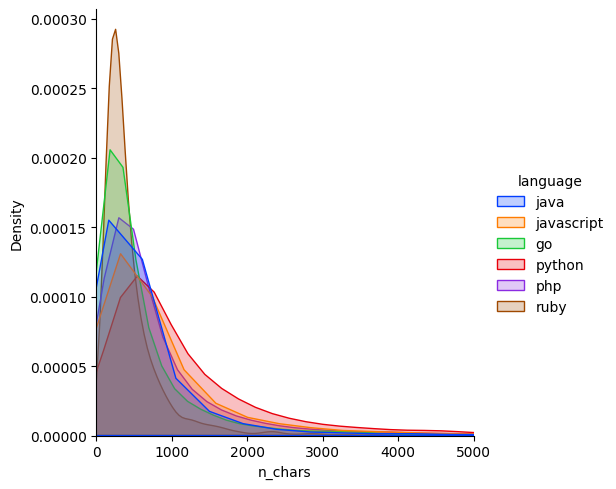

In [11]:
plot = sns.displot(data=df_train, x='n_chars',
                   hue='language', kind='kde', fill=True, 
                   palette=sns.color_palette('bright')[:6])
plot.set(xlim=(0, 5000))

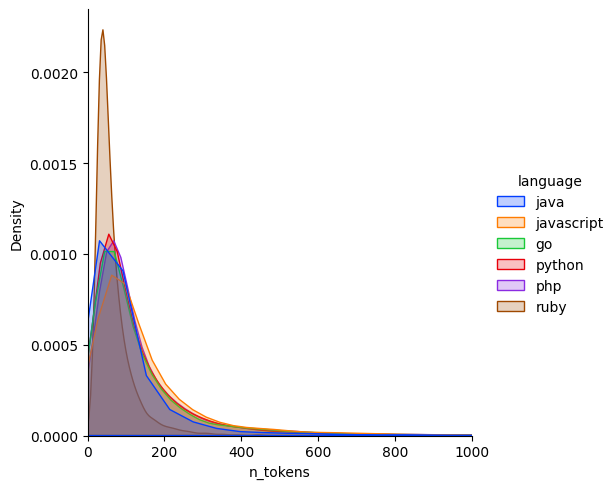

In [12]:
plot = sns.displot(data=df_train, x='n_tokens',
                   hue='language', kind='kde', fill=True, 
                   palette=sns.color_palette('bright')[:6])
plot.set(xlim=(0, 1000))

## Feature extraction
* Tokenize code
* Select identifiers
* Split identifiers
* ngrams

**How to tokenize**

In [12]:
code = """
def sum(a: int, b: custom_int) -> int:
    return a + b
"""

def print_aligned_pair(first, second):
    print(f"{first}\t'{second}'".expandtabs(30))

lexer = get_lexer_by_name("python", stripall=True)
tokens = list(lexer.get_tokens(code))
print("All tokens:")
for token_type, token in tokens:
    print_aligned_pair(token_type, token)

All tokens:
Token.Keyword                 'def'
Token.Text                    ' '
Token.Name.Function           'sum'
Token.Punctuation             '('
Token.Name                    'a'
Token.Punctuation             ':'
Token.Text                    ' '
Token.Name.Builtin            'int'
Token.Punctuation             ','
Token.Text                    ' '
Token.Name                    'b'
Token.Punctuation             ':'
Token.Text                    ' '
Token.Name                    'custom_int'
Token.Punctuation             ')'
Token.Text                    ' '
Token.Operator                '-'
Token.Operator                '>'
Token.Text                    ' '
Token.Name.Builtin            'int'
Token.Punctuation             ':'
Token.Text                    '
'
Token.Text                    '    '
Token.Keyword                 'return'
Token.Text                    ' '
Token.Name                    'a'
Token.Text                    ' '
Token.Operator                '+'
Token.Text 

**Let's select only specific tokens**

In [13]:
filtered_tokens = []
for token_type, token in tokens:
    if token_type in Token.Name:
        print_aligned_pair(token_type, token)
        filtered_tokens.append(token)

print()
print("Tokens after filtration")
print(" ".join(filtered_tokens))

Token.Name.Function           'sum'
Token.Name                    'a'
Token.Name.Builtin            'int'
Token.Name                    'b'
Token.Name                    'custom_int'
Token.Name.Builtin            'int'
Token.Name                    'a'
Token.Name                    'b'

Tokens after filtration
sum a int b custom_int int a b


**Let's split tokens**

In [15]:
token_parser = TokenParser(single_shot=True)
examples = ["Ifc2x3tc1Package", "IFC_ACTION_REQUEST", "IfcActionRequest", "theEObject", "result",
            "caseIfcActionRequest", "dict_modifiers", "kwargs_from_keyword", "get_annotations"]

for token in examples:
    print_aligned_pair(token, str(list(token_parser(token))))

Ifc2x3tc1Package              '['ifc', 'packag']'
IFC_ACTION_REQUEST            '['ifc', 'action', 'request']'
IfcActionRequest              '['ifc', 'action', 'request']'
theEObject                    '['the', 'object']'
result                        '['result']'
caseIfcActionRequest          '['case', 'ifc', 'action', 'request']'
dict_modifiers                '['dict', 'modifi']'
kwargs_from_keyword           '['kwargs', 'from', 'keyword']'
get_annotations               '['get', 'annot']'


In [17]:
def func2subtokens(func_body: str, language: str) -> List[str]:
    """Extract tokens and split into subtokens"""
    res = []
    lexer = get_lexer_by_name(language, stripall=True)
    token_parser = TokenParser(single_shot=True)
    
    for token_type, token in lexer.get_tokens(func_body):
        if token_type in Token.Name:
            res.extend(token_parser(token))
    return res
    

In [19]:
func2subtokens(func_body=code, language="python")

['sum', 'int', 'custom', 'int', 'int']

In [20]:
filtered_tokens

['sum', 'a', 'int', 'b', 'custom_int', 'int', 'a', 'b']

In [21]:
subtokenized_funcs = []
for _, (language, func_body) in tqdm(df_train[["language", "original_string"]].iterrows(), total=df_train.shape[0]):
    subtokenized_funcs.append(func2subtokens(func_body=func_body, language=language))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [22]:
if False:
    with open("subtokenized_funcs.jsonl", "w") as f:
        for line in tqdm(subtokenized_funcs):
            f.write(json.dumps(line) + "\n")

if False:
    subtokenized_funcs = []
    with open("subtokenized_funcs.jsonl") as f:
        for line in tqdm(f):
            subtokenized_funcs.append(json.loads(line))

Let us take dataset and preprocess it:

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(subtokenized_funcs, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[subtokenized_funcs], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [24]:
def ngrammization(subtokenized_funcs):
    """Form Bigrams, Trigrams"""
    texts = [bigram_mod[doc] for doc in tqdm(subtokenized_funcs, desc="Bigrams in progress...")]
    texts = [trigram_mod[bigram_mod[doc]] for doc in tqdm(texts, desc="Trigrams in progress...")]  
    return texts

In [25]:
data_ready = ngrammization(subtokenized_funcs)  # processed Text Data!

Bigrams in progress...:   0%|          | 0/30000 [00:00<?, ?it/s]

Trigrams in progress...:   0%|          | 0/30000 [00:00<?, ?it/s]

In [27]:
data_ready[-100:]

[['irc',
  'downcas',
  'irc',
  'string',
  'casemap',
  'result',
  'irc',
  'string',
  'dup',
  'irc',
  'downcas',
  'result',
  'casemap',
  'result'],
 ['name',
  'self',
  'value',
  'self',
  'complet',
  'not',
  'set',
  'self',
  'name',
  'self',
  'name',
  'value',
  'value'],
 ['tag', 'direct', 'tag', 'name', 'list', 'list', 'includ', 'tag', 'name'],
 ['top',
  'level',
  'top',
  'level',
  'toplevel',
  'listen',
  'first',
  'control',
  'control'],
 ['get',
  'requir',
  'snippet',
  'requir',
  'file',
  'scope',
  'erb',
  'new',
  'sublim',
  'sunippett',
  'templat',
  'requir',
  'sunippet',
  'templat',
  'result',
  'bind'],
 ['run',
  'argv',
  'docopt',
  'exec',
  'argv',
  'docopt',
  'exit',
  'puts',
  'messag',
  'exit'],
 ['structur',
  'names',
  'names',
  'array',
  'new',
  'structur',
  'each',
  'names',
  'name',
  'names'],
 ['enqueu',
  'number',
  'second',
  'from',
  'now',
  'klass',
  'args',
  'enqueu',
  'time',
  'now',
  'number',
  

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

The topic modelling we use is Latent Dirichlet Allocation. We have to skip the details here, but you can find all the details in [the original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf).

In [29]:
# Build LDA model
random.shuffle(corpus)
n_topics = 32
lda_model = gensim.models.ldamodel.LdaModel(corpus=tqdm(corpus),
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=0,
                                           chunksize=128,
                                           passes=4,
                                           alpha='symmetric',
                                           iterations=40,
                                           per_word_topics=True)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [30]:
pprint(lda_model.print_topics())

[(22,
  '0.031*"get" + 0.028*"request" + 0.022*"list" + 0.017*"self" + '
  '0.012*"resourc" + 0.011*"instanc" + 0.011*"config" + 0.010*"path" + '
  '0.010*"error" + 0.009*"class"'),
 (23,
  '0.040*"new" + 0.020*"set" + 0.016*"state" + 0.015*"name" + 0.012*"runtim" + '
  '0.012*"list" + 0.010*"option" + 0.010*"key" + 0.009*"get" + 0.009*"args"'),
 (8,
  '0.030*"self" + 0.024*"set" + 0.020*"err" + 0.015*"list" + 0.012*"state" + '
  '0.011*"key" + 0.010*"index" + 0.010*"get" + 0.009*"value" + 0.009*"start"'),
 (30,
  '0.025*"name" + 0.024*"get" + 0.015*"err" + 0.013*"config" + 0.012*"target" '
  '+ 0.012*"set" + 0.011*"value" + 0.010*"match" + 0.010*"result" + '
  '0.009*"image"'),
 (5,
  '0.049*"err" + 0.024*"name" + 0.018*"self" + 0.017*"get" + 0.013*"new" + '
  '0.013*"info" + 0.012*"index" + 0.011*"context" + 0.011*"option" + '
  '0.010*"params"'),
 (1,
  '0.023*"get" + 0.020*"config" + 0.014*"task" + 0.013*"type" + 0.012*"file" + '
  '0.012*"context" + 0.011*"configur" + 0.010*"item"

/tmp/ipykernel_532/1446963044.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  plot = sns.displot(data=doc_lens,


<Figure size 2560x1120 with 0 Axes>

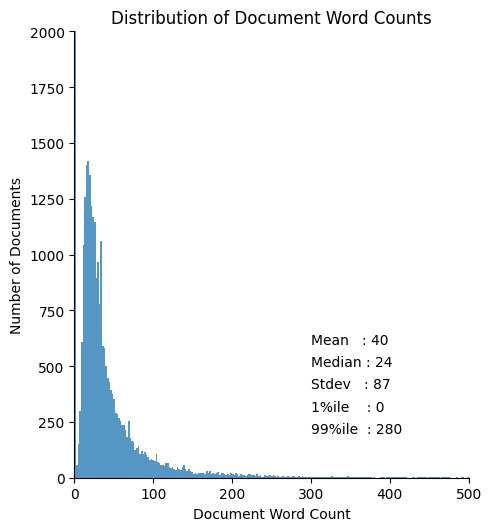

In [31]:
plt.figure(figsize=(16,7), dpi=160)
doc_lens = [len(d) for d in data_ready]
plot = sns.displot(data=doc_lens,
                   palette=sns.color_palette('bright'))

plt.text(300, 600, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(300, 500, "Median : " + str(round(np.median(doc_lens))))
plt.text(300, 400, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(300, 300, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(300, 200, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plot.set(xlim=(0, 500), ylim=(0, 2000), title='Distribution of Document Word Counts',
         ylabel='Number of Documents', xlabel='Document Word Count')

Let us look at the corpus and output model more precisely:

In [32]:
topics = lda_model.show_topics(n_topics, formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

/tmp/ipykernel_532/3772387375.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_532/3772387375.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_532/3772387375.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
/tmp/ipykernel_532/3772387375.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')


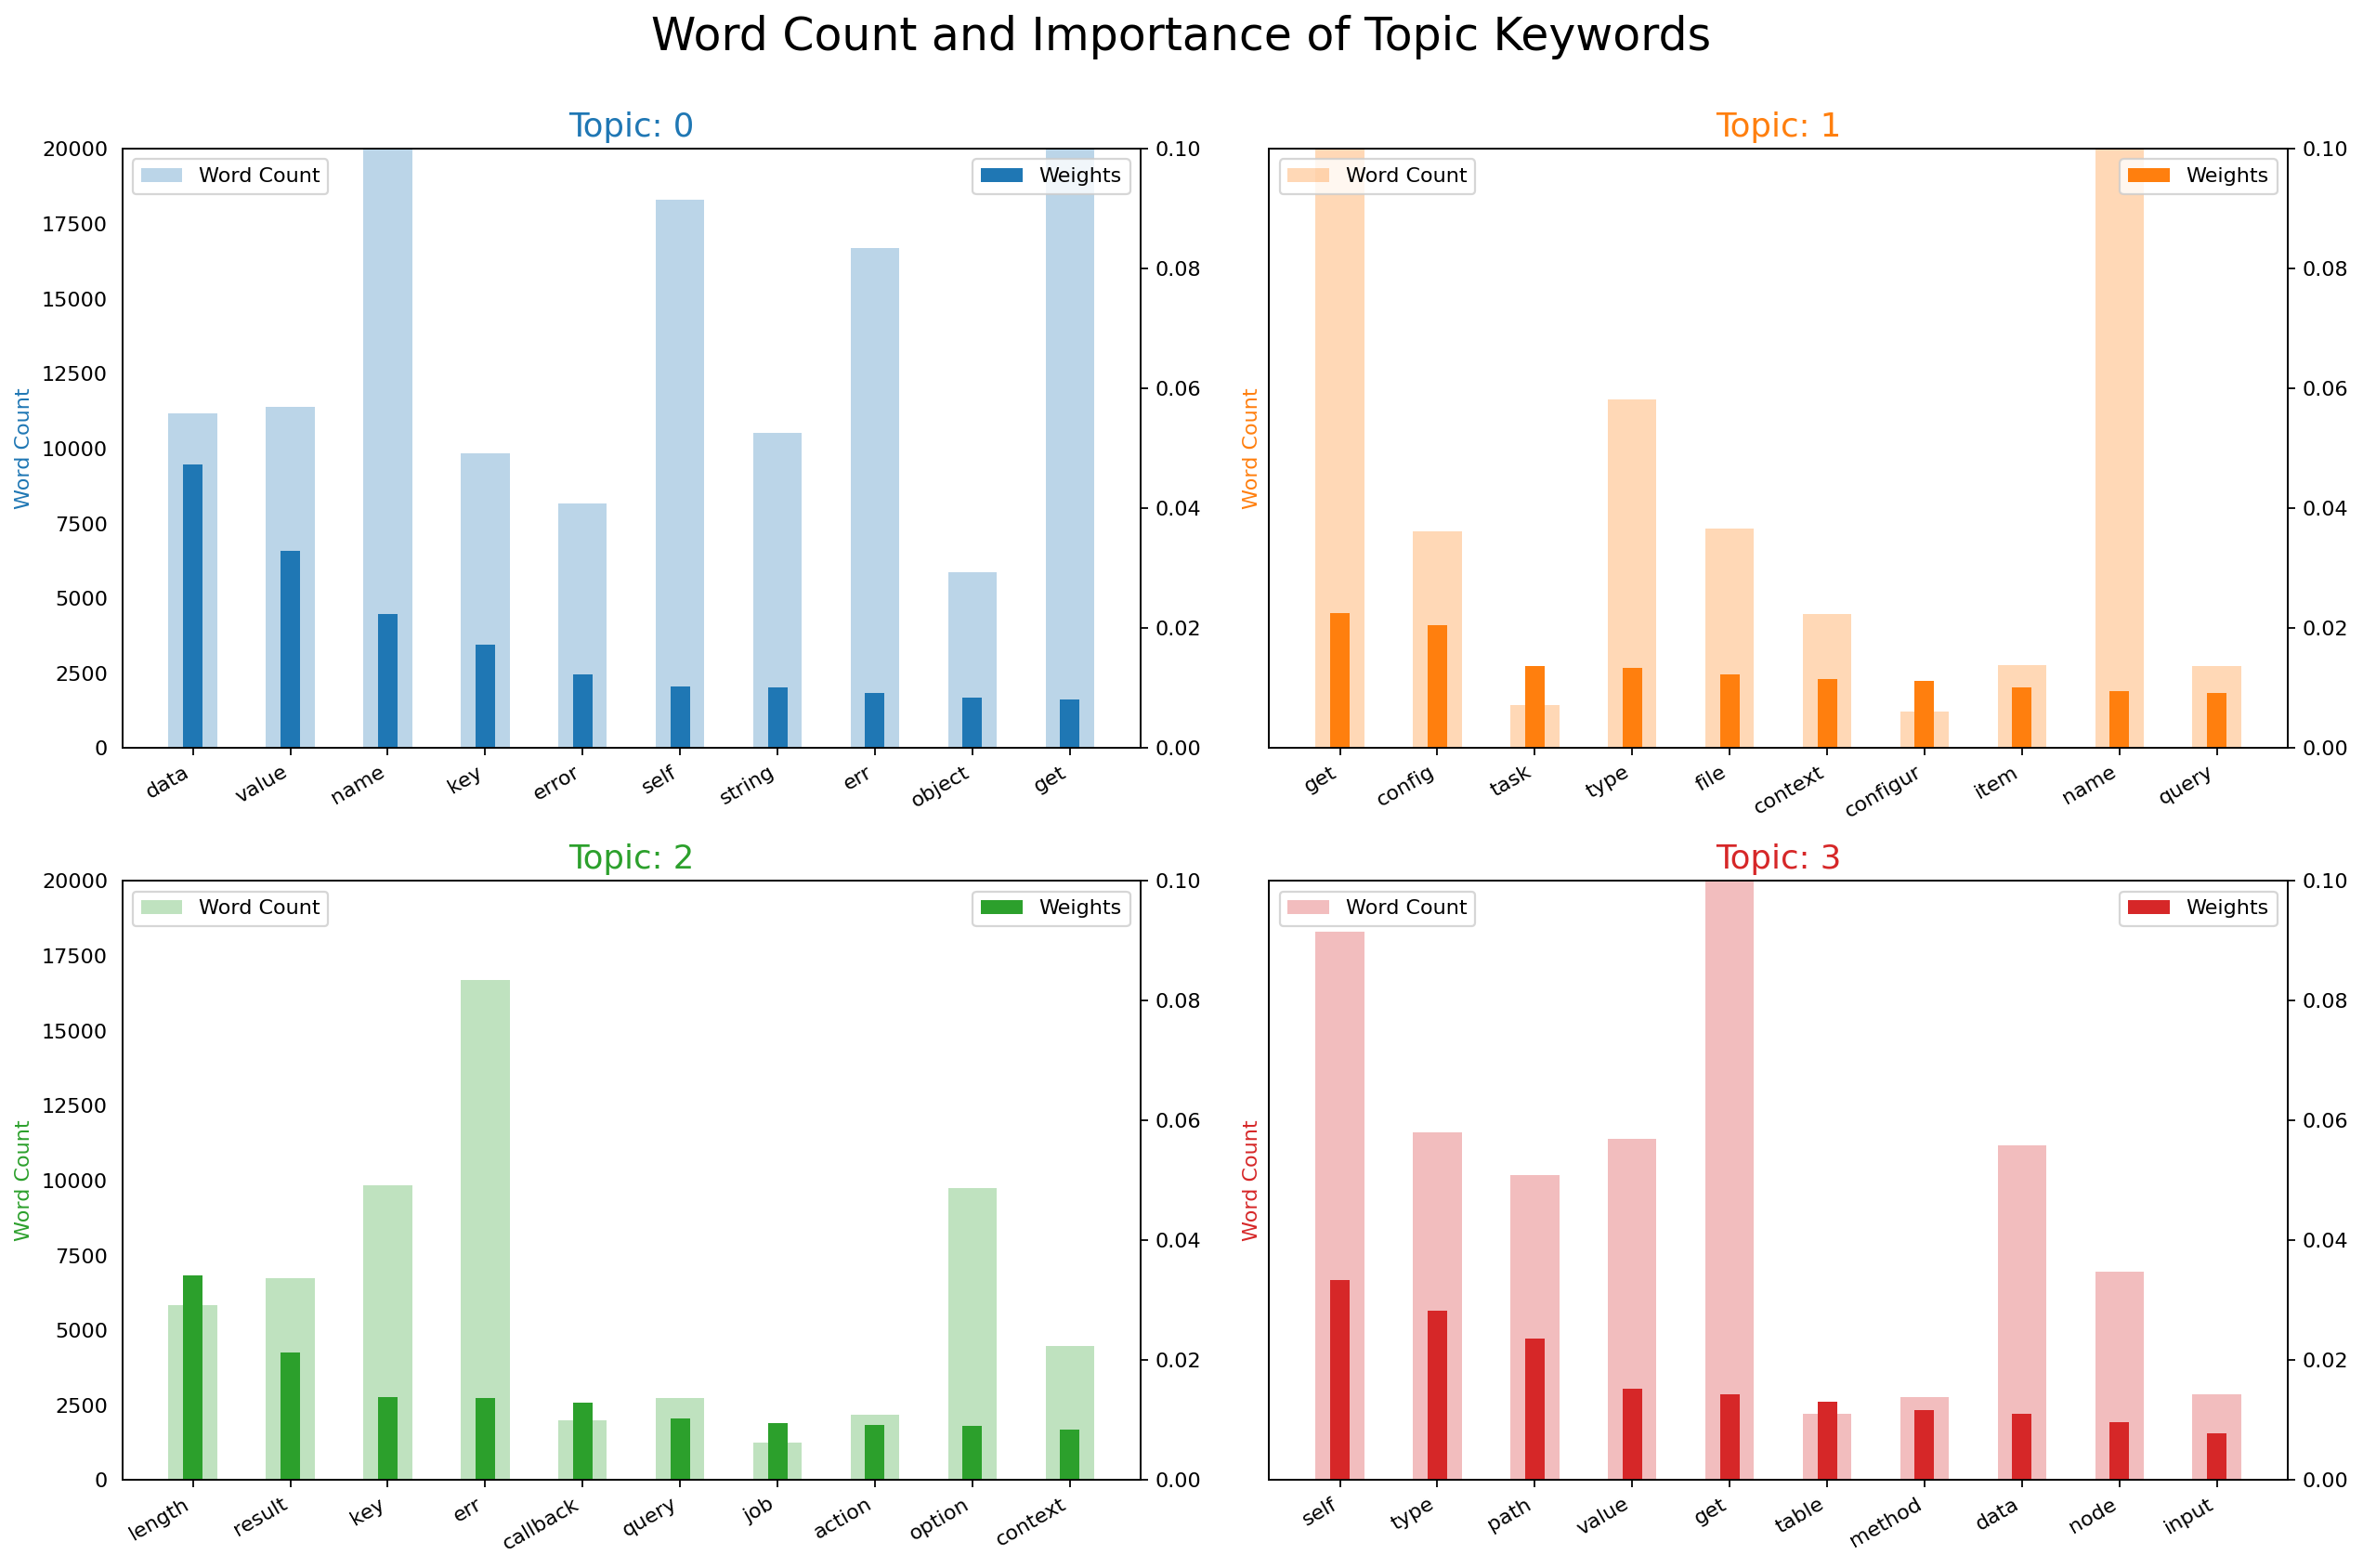

In [39]:
# Plot Word Count and Weights of Topic Keywords

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 20000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [40]:
# Sentence Coloring of N Sentences


def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=1000):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i - 1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i - 1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange            
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0] % len(mycolors)], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics % len(mycolors)],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end -1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

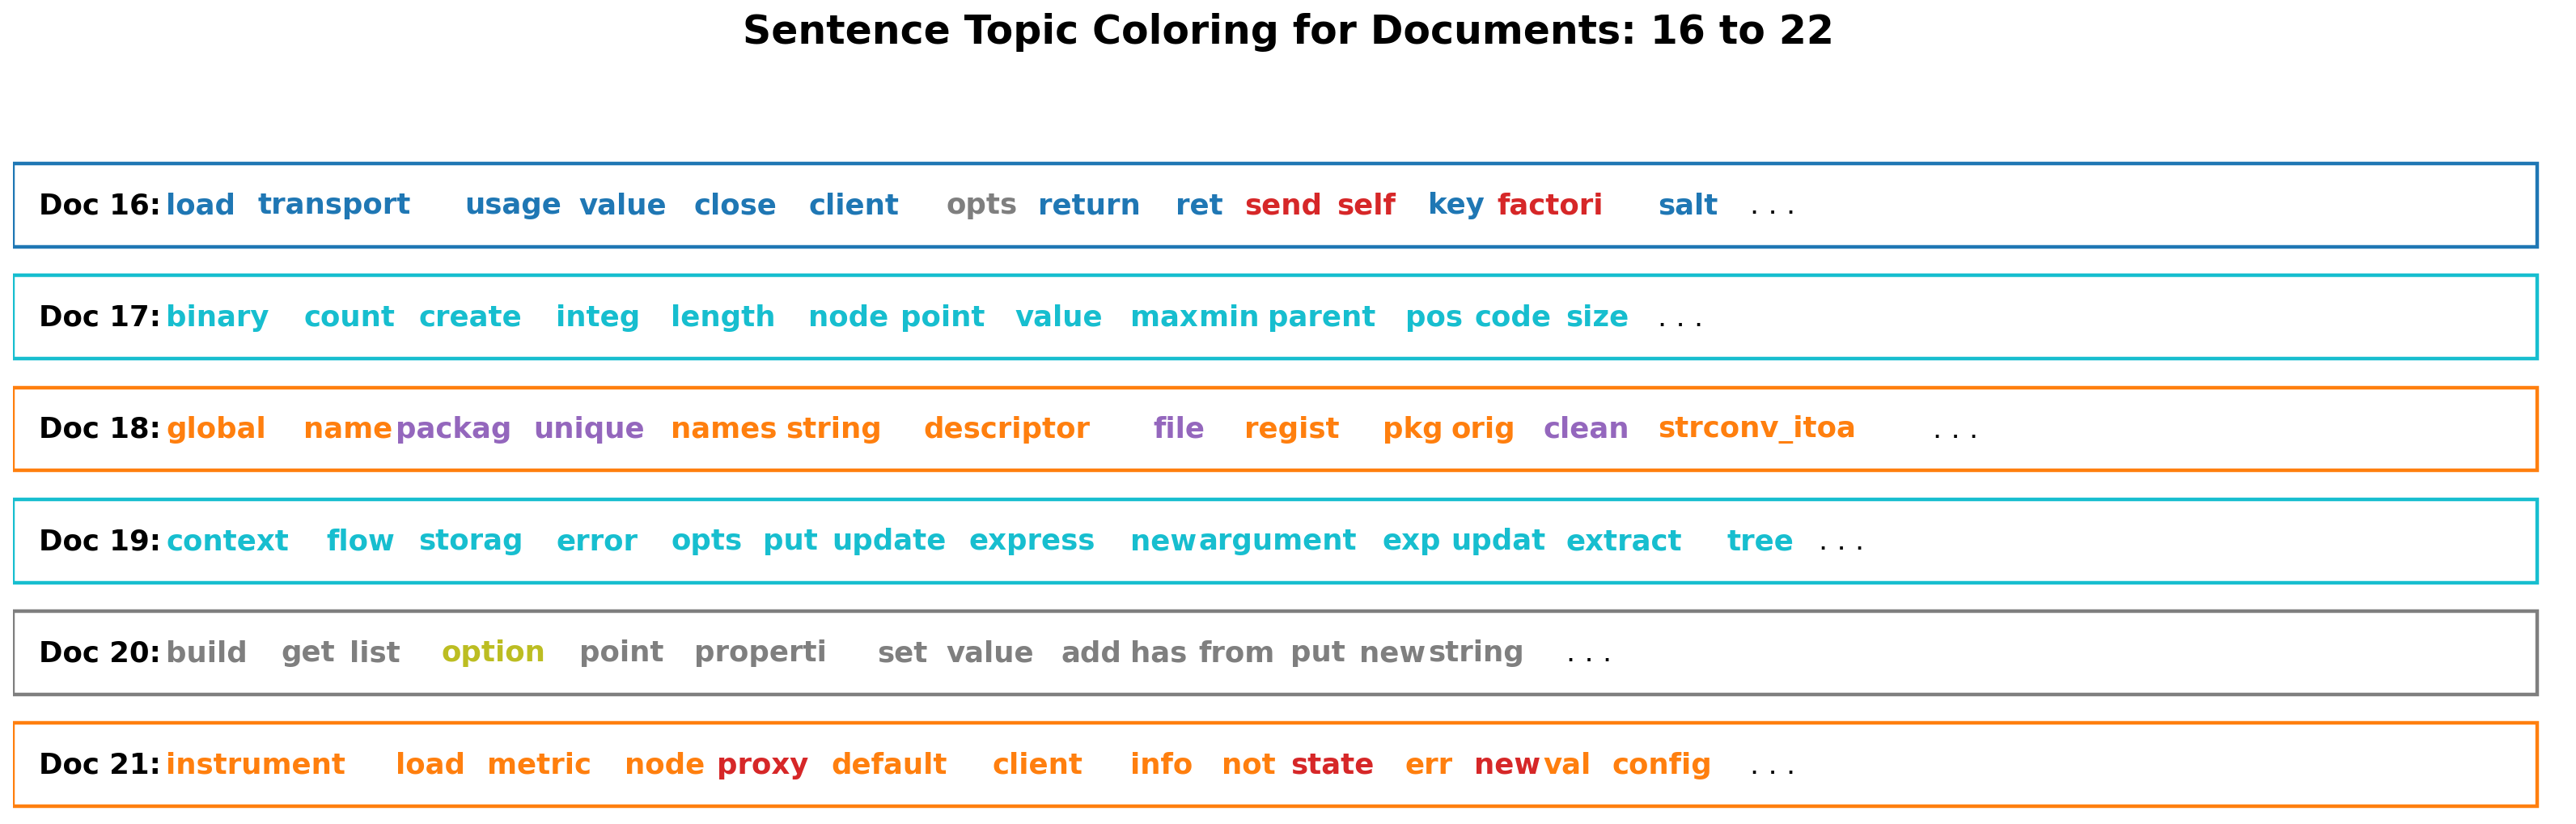

In [41]:
sentences_chart(start=16, end=23)  

For the final part we need an additional tool for visualization:

In [42]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus[:2000], dictionary=lda_model.id2word)
vis

/home/egor/workspace/nlp-course/venv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20     0.018269 -0.036418       1        1  5.326664
5     -0.021778  0.008403       2        1  4.837024
11     0.010740  0.042973       3        1  4.689191
0     -0.003731  0.008428       4        1  4.352891
4      0.001209  0.002026       5        1  4.220462
30    -0.005118 -0.000035       6        1  4.036808
29    -0.017336  0.021182       7        1  3.616826
19     0.118877  0.028118       8        1  3.579802
22    -0.032383 -0.024373       9        1  3.449518
27    -0.005003 -0.003753      10        1  3.396873
6      0.018075  0.047229      11        1  3.315009
16     0.022467  0.015045      12        1  3.294706
18    -0.030112  0.063181      13        1  3.212895
31    -0.003652 -0.012151      14        1  3.115373
15    -0.059462  0.002347      15        1  3.106547
8      0.013723 -0.044463      16        1  3.063325
26     0.081237 -0.050082      17        1  2.909787
12    -0.012071  0.037889      18        1  2.857232
13    -0.005411 -0.035345      19        1  2.812670
10    -0.009385 -0.073808      20        1  2.787978
21    -0.045144  0.064405      21        1  2.777850
24    -0.051781 -0.001041      22        1  2.677735
17     0.031371  0.044648      23        1  2.671958
23    -0.005730 -0.010689      24        1  2.663126
2      0.065913  0.019036      25        1  2.623656
1     -0.036611 -0.003796      26        1  2.589021
7     -0.001826 -0.057624      27        1  2.234106
28    -0.033474 -0.027226      28        1  2.227046
9     -0.053645 -0.007829      29        1  2.212201
25     0.013553 -0.005673      30        1  2.063130
3      0.001991 -0.020818      31        1  1.706682
14     0.036226  0.010216      32        1  1.571905, topic_info=        Term         Freq        Total Category  logprob  loglift
999     self  1057.000000  1057.000000  Default  30.0000  30.0000
746      err   992.000000   992.000000  Default  29.0000  29.0000
314     node   495.000000   495.000000  Default  28.0000  28.0000
310     name  1296.000000  1296.000000  Default  27.0000  27.0000
233      ifc   258.000000   258.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
999     self     7.835337  1057.400786  Topic32  -5.0366  -0.7520
338     path     6.787772   620.099084  Topic32  -5.1801  -0.3619
555   append     5.332353   226.025205  Topic32  -5.4215   0.4060
101  context     5.342364   281.890607  Topic32  -5.4196   0.1870
824   config     5.353765   463.725201  Topic32  -5.4175  -0.3086

[2697 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
14063      9  1.375777     abs_corr
1514       2  0.025783      account
1514       3  0.025783      account
1514       4  0.025783      account
1514       5  0.025783      account
...      ...       ...          ...
1277      19  0.037794          zip
1277      22  0.037794          zip
1277      25  0.151178          zip
1277      28  0.037794          zip
4800      19  1.010627  zone_letter

[11263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 6, 12, 1, 5, 31, 30, 20, 23, 28, 7, 17, 19, 32, 16, 9, 27, 13, 14, 11, 22, 25, 18, 24, 3, 2, 8, 29, 10, 26, 4, 15])

/home/egor/workspace/nlp-course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/egor/workspace/nlp-course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/egor/workspace/nlp-course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/egor/workspace/nlp-course/venv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/egor/workspace/nlp-course/venv